# Решающие деревья

## Подготовка данных

Для классификации

In [3]:
import pandas as pd

cdata = pd.read_csv('D:/PythonWork/Machine learning and big data/data/diabet_processed.csv', encoding='utf-8', delimiter=',')
cdata.drop(['Unnamed: 0'], axis=1, inplace=True)
cdata

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,True,True,True,40,True,False,False,False,False,True,False,True,False,5,18,15,True,False,9,4,3
1,0,False,False,False,25,True,False,False,True,False,False,False,False,True,3,0,0,False,False,7,6,1
2,0,True,True,True,28,False,False,False,False,True,False,False,True,True,5,30,30,True,False,9,4,8
3,0,True,False,True,27,False,False,False,True,True,True,False,True,False,2,0,0,False,False,11,3,6
4,0,True,True,True,24,False,False,False,True,True,True,False,True,False,2,3,0,False,False,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243828,0,False,False,True,27,False,False,False,False,False,True,False,True,False,1,0,0,False,False,3,6,5
243829,2,True,True,True,18,False,False,False,False,False,False,False,True,False,4,0,0,True,False,11,2,4
243830,0,False,False,True,28,False,False,False,True,True,False,False,True,False,1,0,0,False,False,2,5,2
243831,0,True,False,True,23,False,False,False,False,True,True,False,True,False,3,0,0,False,True,7,5,1


Для регрессии

In [4]:
import pandas as pd

rdata = pd.read_csv('D:/PythonWork/Machine learning and big data/data/taxi_duration_processed.csv', encoding='utf-8', delimiter=',')
rdata.drop(['Unnamed: 0', 'id', 'pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True)
rdata

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,route_len,month,hour,week_day
0,2,1,-73.953918,40.778873,-73.963875,40.771164,400,1.397743,2,16,0
1,1,2,-73.988312,40.731743,-73.994751,40.694931,1100,4.148155,3,23,4
2,2,2,-73.997314,40.721458,-73.948029,40.774918,1635,8.070991,2,17,6
3,1,1,-74.017120,40.708469,-73.988182,40.740631,848,4.802338,2,6,2
4,2,2,-73.993614,40.751884,-73.995422,40.723862,1455,3.116996,2,18,6
...,...,...,...,...,...,...,...,...,...,...,...
572663,2,1,-73.974487,40.783138,-73.952629,40.772270,449,2.709620,1,22,0
572664,2,2,-73.965919,40.789780,-73.952637,40.789181,296,1.475886,5,13,5
572665,1,1,-73.996666,40.737434,-74.001320,40.731911,315,0.801741,2,0,0
572666,1,1,-73.997849,40.761696,-74.001488,40.741207,673,2.309847,4,18,4


In [5]:
rX = rdata.drop('trip_duration', axis=1)
ry = rdata['trip_duration']

Балансирование набора данных

In [6]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

cX = cdata.drop('Diabetes_012', axis=1)
cy = cdata['Diabetes_012']

tf_df, t_label_df = oversample.fit_resample(cX, cy)

balanced_df = pd.concat([t_label_df, tf_df], axis=1, join='outer')

cbX = balanced_df.drop('Diabetes_012', axis=1)
cby = balanced_df['Diabetes_012']

### Разделение данных на тестовую и обучающую выборки

Датасет классификации

hold-out

In [7]:
from sklearn.model_selection import train_test_split

cX_ho_train, cX_ho_test, cy_ho_train, cy_ho_test = train_test_split(cbX, cby, test_size=0.2, random_state=42, stratify=cby)

k-fold

In [8]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(cbX):
    cX_kf_train, cX_kf_test = cbX.iloc[train_index], cbX.iloc[test_index]
    cy_kf_train, cy_kf_test = cby.iloc[train_index], cby.iloc[test_index]


Датасет регрессии

hold-out

In [9]:
from sklearn.model_selection import train_test_split

rX_ho_train, rX_ho_test, ry_ho_train, ry_ho_test = train_test_split(rX, ry, test_size=0.2, random_state=42, stratify=ry)

K-fold

In [10]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(rX):
    rX_kf_train, rX_kf_test = rX.iloc[train_index], rX.iloc[test_index]
    ry_kf_train, ry_kf_test = ry.iloc[train_index], ry.iloc[test_index]


### DecisionTree Classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier

ctree = DecisionTreeClassifier(max_depth=3)
ctree.fit(cX_ho_train, cy_ho_train)

DecisionTreeClassifier(max_depth=3)

In [11]:
from sklearn import tree

text_representation = tree.export_text(ctree)
print(text_representation)

|--- feature_13 <= 2.50
|   |--- feature_18 <= 7.50
|   |   |--- feature_3 <= 29.50
|   |   |   |--- class: 0
|   |   |--- feature_3 >  29.50
|   |   |   |--- class: 0
|   |--- feature_18 >  7.50
|   |   |--- feature_20 <= 7.50
|   |   |   |--- class: 1
|   |   |--- feature_20 >  7.50
|   |   |   |--- class: 0
|--- feature_13 >  2.50
|   |--- feature_0 <= 0.50
|   |   |--- feature_20 <= 7.50
|   |   |   |--- class: 1
|   |   |--- feature_20 >  7.50
|   |   |   |--- class: 0
|   |--- feature_0 >  0.50
|   |   |--- feature_10 <= 0.50
|   |   |   |--- class: 2
|   |   |--- feature_10 >  0.50
|   |   |   |--- class: 0



<Figure size 2500x2000 with 0 Axes>

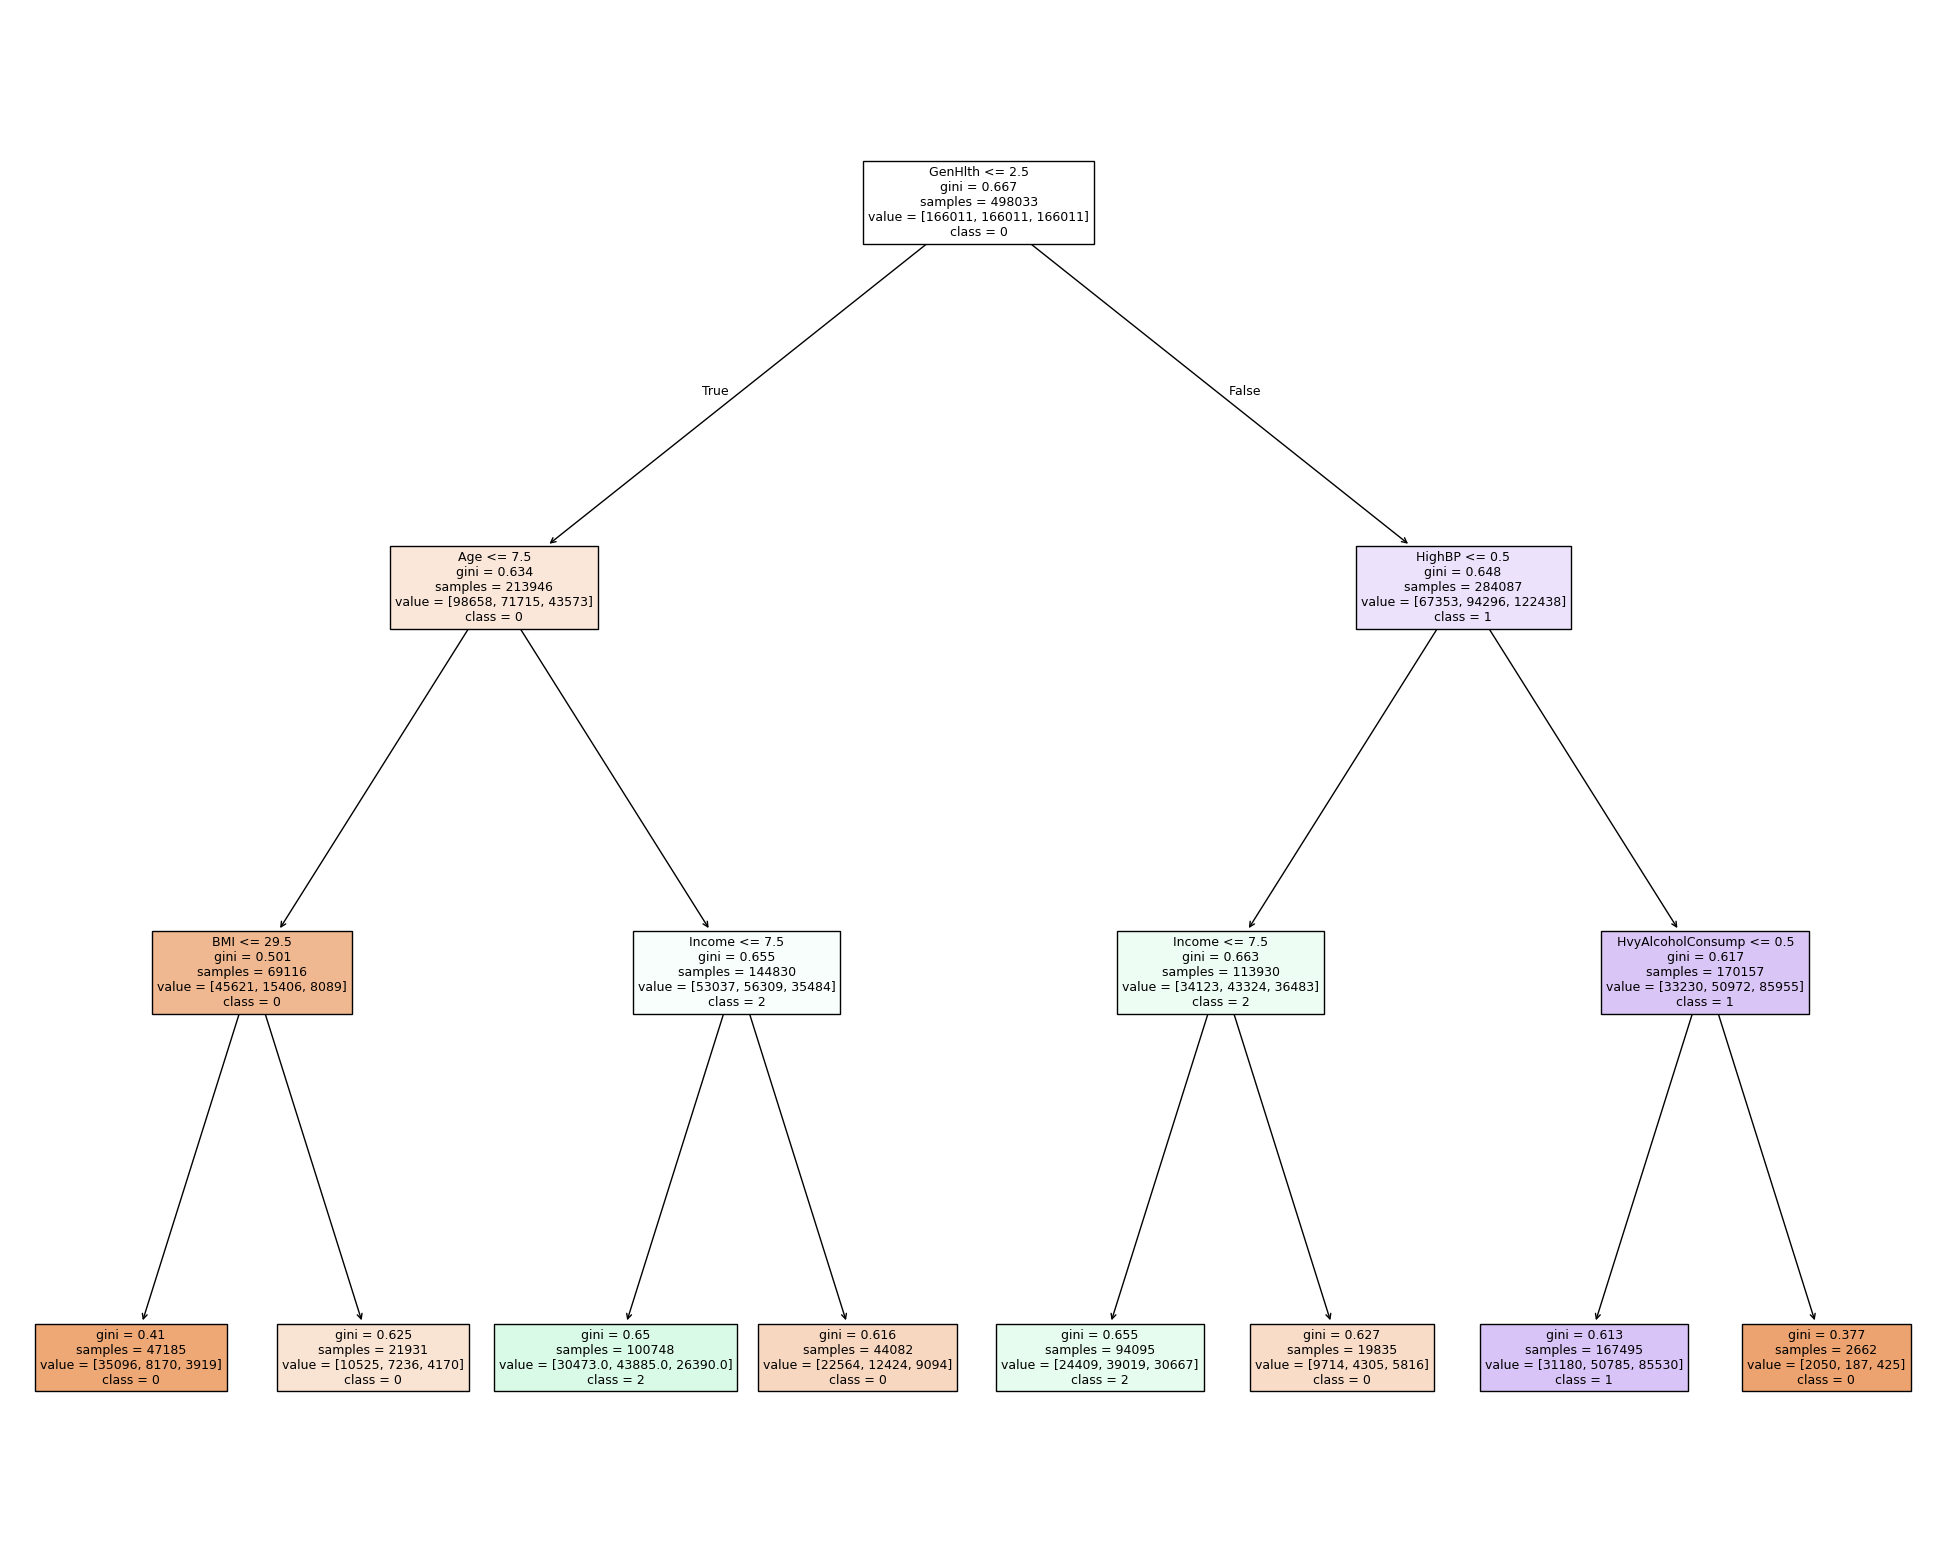

In [12]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25,20))
plt.figure(figsize=(25,20))
_ = tree.plot_tree(ctree, feature_names=cbX.columns.tolist(), class_names=cdata[cby.name].unique().astype(str), filled=True)

Подбор гиперпараметров

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'max_depth': [None, 10, 20, 30],   
    'min_samples_split': randint(low=2, high=11),     
    'min_samples_leaf': randint(low=1, high=5),       
    'criterion': ['gini', 'entropy'],               
    'splitter': ['best', 'random']                  
}

ctree = DecisionTreeClassifier()

rand_search = RandomizedSearchCV(
    estimator=ctree,
    param_distributions=param_dist,
    n_iter=50,               
    cv=2,                      
    verbose=2,                
    random_state=42            
)

rand_search.fit(cX_ho_train, cy_ho_train)

print("Лучшие гиперпараметры:", rand_search.best_params_)

best_model = rand_search.best_estimator_
test_accuracy = best_model.score(cX_ho_test, cy_ho_test)
print(f"Точность на тестовых данных: {test_accuracy:.2f}")

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=9, splitter=best; total time=   1.2s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=9, splitter=best; total time=   1.3s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, splitter=best; total time=   1.7s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, splitter=best; total time=   1.9s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=4, min_samples_split=6, splitter=random; total time=   1.4s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=4, min_samples_split=6, splitter=random; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   1.3s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   1.2s
[CV] END criteri

### DecisionTree Regressor

In [17]:
from sklearn.tree import DecisionTreeRegressor

rtree = DecisionTreeRegressor(max_depth=3)
rtree.fit(rX_ho_train, ry_ho_train)

DecisionTreeRegressor(max_depth=3)

In [18]:
text_representation = tree.export_text(rtree)
print(text_representation)

|--- feature_6 <= 2.58
|   |--- feature_6 <= 1.49
|   |   |--- feature_6 <= 1.02
|   |   |   |--- value: [300.97]
|   |   |--- feature_6 >  1.02
|   |   |   |--- value: [428.55]
|   |--- feature_6 >  1.49
|   |   |--- feature_8 <= 7.50
|   |   |   |--- value: [464.00]
|   |   |--- feature_8 >  7.50
|   |   |   |--- value: [635.20]
|--- feature_6 >  2.58
|   |--- feature_6 <= 4.29
|   |   |--- feature_8 <= 7.50
|   |   |   |--- value: [671.08]
|   |   |--- feature_8 >  7.50
|   |   |   |--- value: [903.05]
|   |--- feature_6 >  4.29
|   |   |--- feature_8 <= 7.50
|   |   |   |--- value: [979.04]
|   |   |--- feature_8 >  7.50
|   |   |   |--- value: [1226.74]



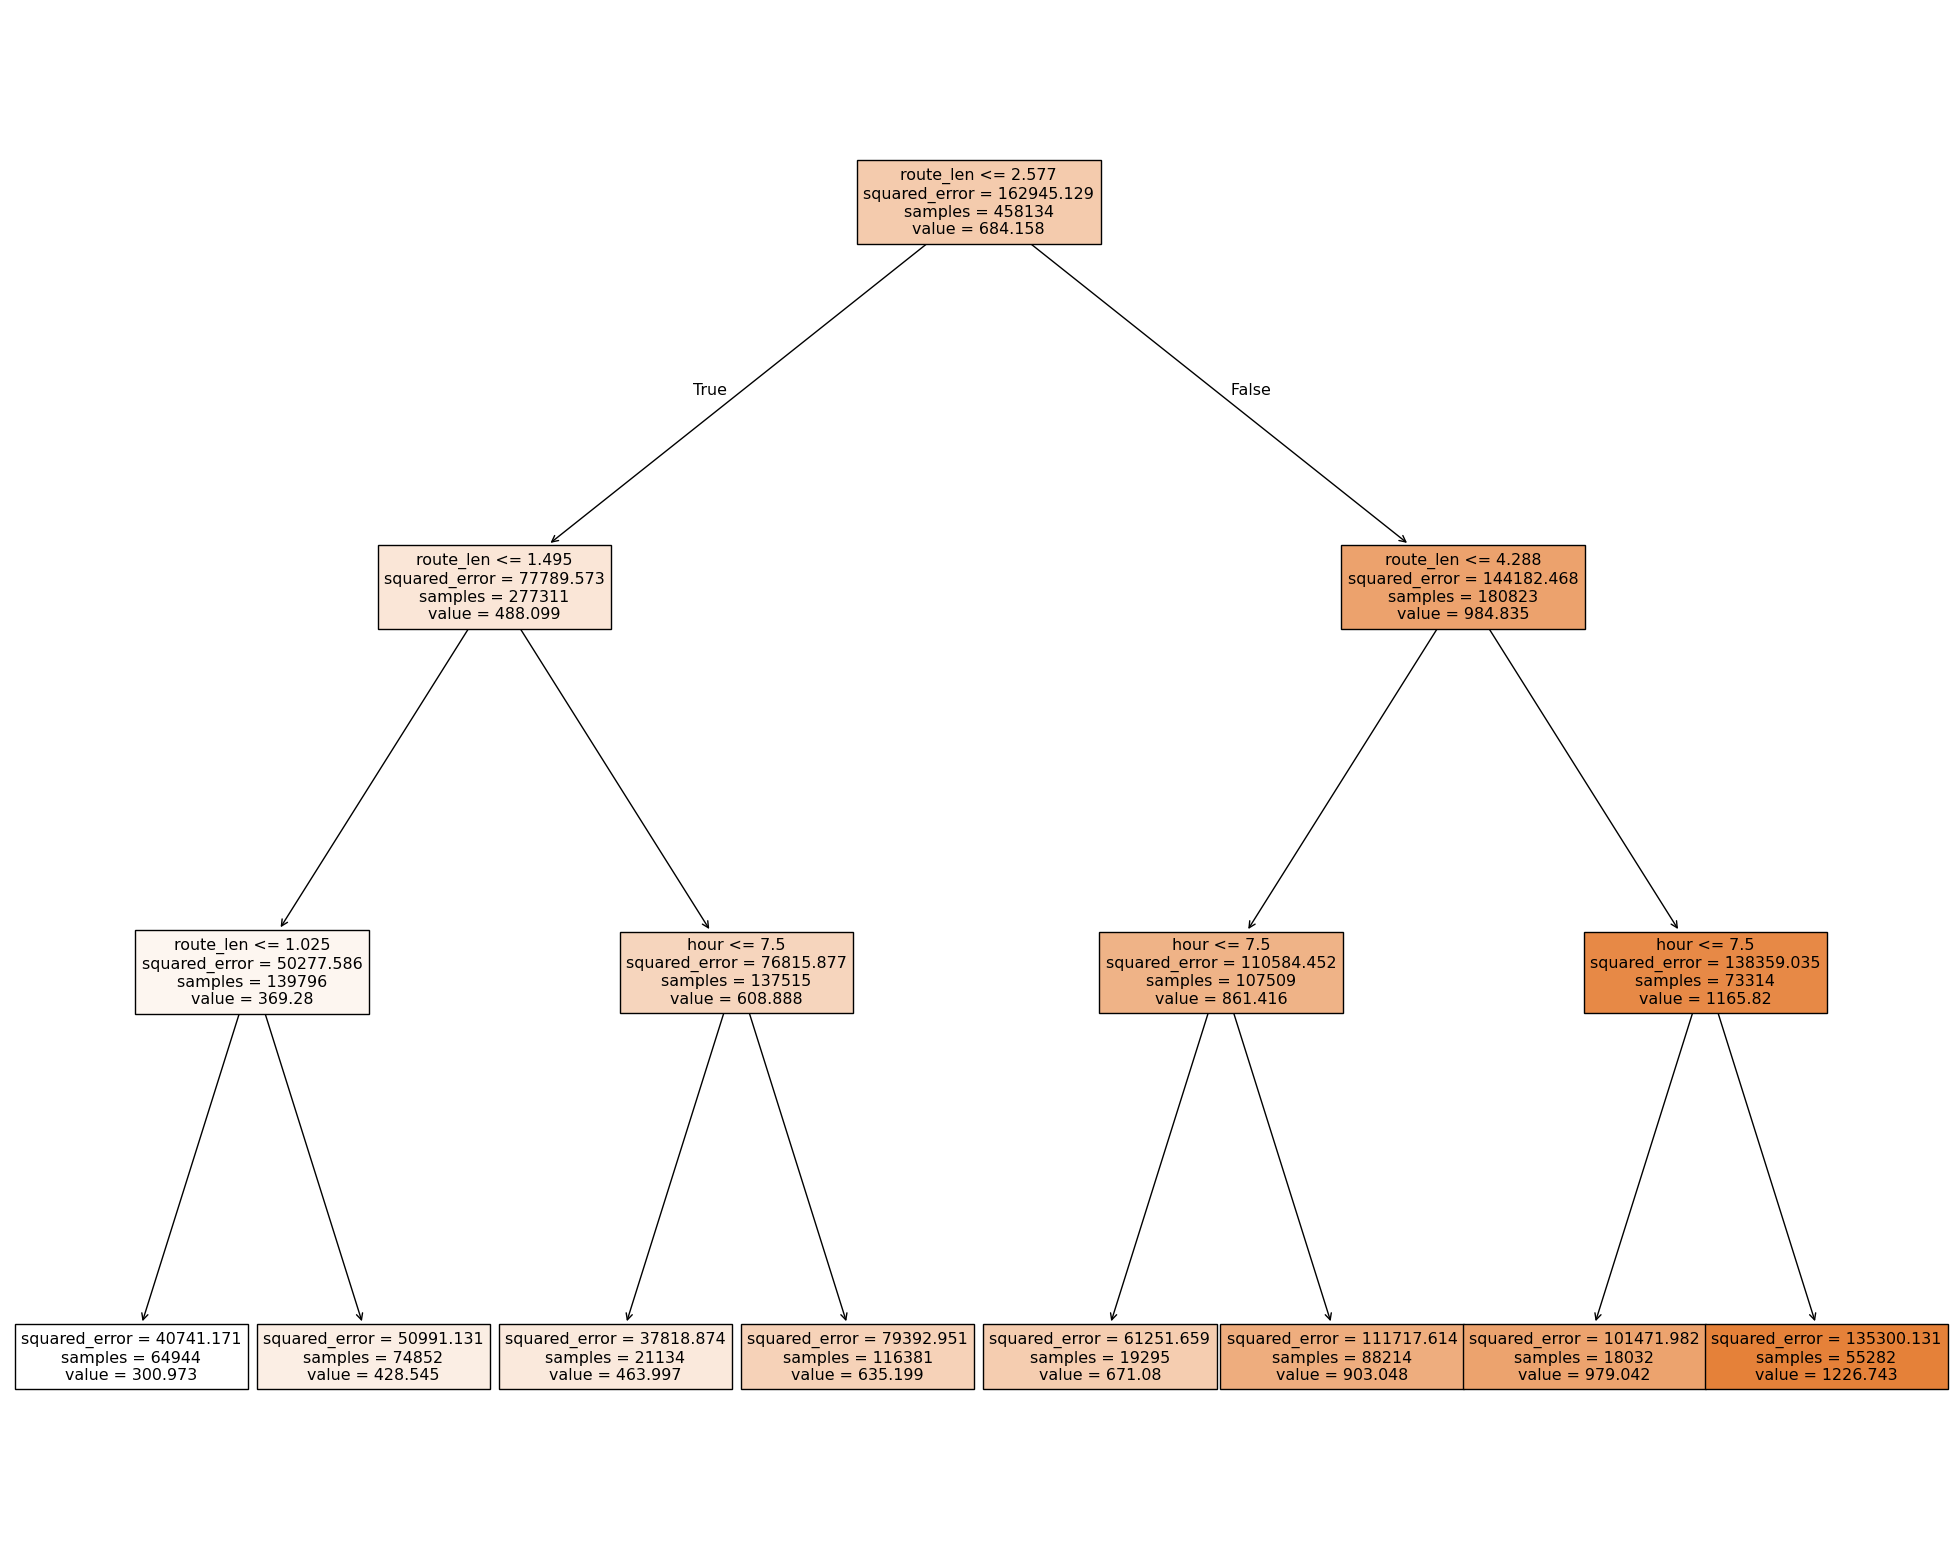

In [19]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(rtree, feature_names=rX.columns.tolist(), class_names=rdata[ry.name].unique().astype(str), filled=True)

Подбор гиперпараметров

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'max_depth': [None, 10, 20],  
    'min_samples_split': randint(low=2, high=6),      
    'min_samples_leaf': randint(low=1, high=3),        
    'criterion': ['squared_error'],                    
    'splitter': ['random'],                            
    'max_features': ['sqrt', 'log2', None]                  
}

rtree = DecisionTreeRegressor()

rand_search = RandomizedSearchCV(
    estimator=rtree,
    param_distributions=param_dist,
    n_iter=50,               
    cv=2,                      
    verbose=2,                
    random_state=42,
    n_jobs=-1             
)

rand_search.fit(rX_kf_train, ry_kf_train)

print("Лучшие гиперпараметры:", rand_search.best_params_)

best_regressor = rand_search.best_estimator_
predictions = best_regressor.predict(rX_ho_test)
score = best_regressor.score(rX_ho_test, ry_ho_test)
print(f"Оценка R^2 на тестовых данных: {score:.2f}")

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Лучшие гиперпараметры: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'splitter': 'random'}
Оценка R^2 на тестовых данных: 0.57


Оценка модели RTree

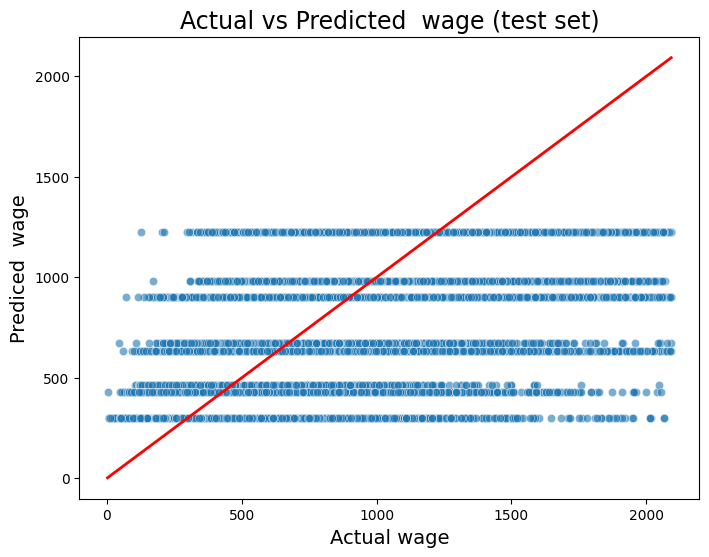

In [18]:
import seaborn as sns

y_hat = rtree.predict(rX_ho_test)

plt.figure(figsize=(8,6))
sns.scatterplot(x=ry_ho_test, y=y_hat, alpha=0.6)
sns.lineplot(x=ry_ho_test, y=ry_ho_test, color='red', linewidth=2)
plt.xlabel('Actual wage', fontsize=14)
plt.ylabel('Prediced  wage', fontsize=14)
plt.title('Actual vs Predicted  wage (test set)', fontsize=17)
plt.show()

In [19]:
import numpy as np

MSE_test = round(np.mean(np.square(ry_ho_test - y_hat)),2)
RMSE_test = round(np.sqrt(MSE_test),2)
float(RMSE_test)

282.69

### Bagging Classifier

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

c_bagging_model = BaggingClassifier(ctree, n_estimators=10, random_state=42)

c_bagging_model.fit(cX_ho_train, cy_ho_train)

y_pred = c_bagging_model.predict(cX_ho_test)

accuracy = accuracy_score(cy_ho_test, y_pred)
print(f"Bagging Classifier Accuracy: {accuracy:.4f}")

Bagging Classifier Accuracy: 0.4979


Подбор гиперпараметров

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

base_model = DecisionTreeClassifier()

param_dist = {
    'n_estimators': [3, 6, 9],    
    'max_samples': [0.5, 0.7, 0.9, 1.0],        
    'bootstrap': [True, False],                   
}

bagging = BaggingClassifier(random_state=42)

random_search = RandomizedSearchCV(
    bagging,
    param_distributions=param_dist,
    n_iter=50,                    
    cv=2,                           
    scoring='accuracy',             
    verbose=2,
    random_state=42,
    n_jobs=-1             
)

random_search.fit(cX_ho_train, cy_ho_train)

print("Лучшие гиперпараметры:", random_search.best_params_)

best_bagging = random_search.best_estimator_
test_accuracy = best_bagging.score(cX_ho_test, cy_ho_test)
print(f"Accuracy на тестовой выборке: {test_accuracy:.2f}")

d:\PythonWork\Machine learning and big data\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 24 candidates, totalling 48 fits
Лучшие гиперпараметры: {'n_estimators': 9, 'max_samples': 1.0, 'bootstrap': True}
Accuracy на тестовой выборке: 0.89


### Bagging Regressor

In [23]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

r_bagging_model = BaggingRegressor(rtree, n_estimators=10, random_state=42)

r_bagging_model.fit(rX_ho_train, ry_ho_train)

y_pred = r_bagging_model.predict(rX_ho_test)

mse = mean_squared_error(ry_ho_test, y_pred) ** (1 / 2)
print(f"Bagging Regressor MSE: {mse:.4f}")

Bagging Regressor MSE: 222.9381


In [25]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

base_model = DecisionTreeRegressor()

param_dist = {
    'n_estimators': [3, 6, 9],    
    'max_samples': [0.5, 0.7, 0.9, 1.0],          
    'bootstrap': [True, False],                    
}

bagging_reg = BaggingRegressor()

random_search = RandomizedSearchCV(
    bagging_reg,
    param_distributions=param_dist,
    n_iter=50,              
    cv=2,                   
    scoring='neg_mean_squared_error',  
    verbose=2,              
    random_state=42,
    n_jobs=-1 
)

random_search.fit(cX_ho_train, cy_ho_train)

# Лучшие гиперпараметры
print("Лучшие гиперпараметры:", random_search.best_params_)

# Точность на тестовой выборке
best_bagging = random_search.best_estimator_
test_mse = mean_squared_error(best_bagging.predict(cX_ho_test), cy_ho_test)
print(f"MSE на тестовой выборке: {test_mse:.2f}")

d:\PythonWork\Machine learning and big data\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 24 candidates, totalling 48 fits
Лучшие гиперпараметры: {'n_estimators': 9, 'max_samples': 0.7, 'bootstrap': False}
MSE на тестовой выборке: 0.28


### Gradient Boosting Classifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gbc = GradientBoostingClassifier(n_estimators=10,
                                 learning_rate=0.05,
                                 random_state=100,
                                 max_features=5 )
                                 
gbc.fit(cX_ho_train, cy_ho_train)

pred_y = gbc.predict(cX_ho_test)

acc = accuracy_score(cy_ho_test, pred_y)
print("Gradient Boosting Classifier accuracy is : {:.2f}".format(acc))

Gradient Boosting Classifier accuracy is : 0.54


Подбор гиперпараметров

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {'n_estimators': [3, 6, 9, 11, 12],
              'max_depth': [3, 5, 7, 10],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf':  [2, 4, 5],
              'loss': ['log_loss']}

gbc = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(
    gbc,
    param_distributions=param_dist,
    n_iter=50,             
    cv=2,                    
    scoring='accuracy',     
    verbose=2,              
    random_state=42,
    n_jobs=-1          
)

reduced_X_train, _, reduced_y_train, _ = train_test_split(cX_ho_train, cy_ho_train, train_size=0.2, stratify=cy_ho_train, random_state=42)

random_search.fit(reduced_X_train, reduced_y_train)

print("Лучшие гиперпараметры:", random_search.best_params_)

best_gbc = random_search.best_estimator_
test_accuracy = best_gbc.score(cX_ho_test, cy_ho_test)
print(f"Accuracy на тестовой выборке: {test_accuracy:.2f}")

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Лучшие гиперпараметры: {'n_estimators': 12, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 10, 'loss': 'log_loss'}
Accuracy на тестовой выборке: 0.64


### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

SEED = 23

gbr = GradientBoostingRegressor(loss='absolute_error',
                                learning_rate=0.1,
                                n_estimators=20,
                                max_depth = 3, 
                                random_state = SEED,
                                max_features = 5)

gbr.fit(rX_ho_train, ry_ho_train)

pred_y = gbr.predict(rX_ho_test)

test_rmse = mean_squared_error(ry_ho_test, pred_y) ** (1 / 2)

print('Root mean Square error: {:.2f}'.format(test_rmse))

Root mean Square error: 280.89


Подбор гиперпараметров

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

param_dist = { 
    'n_estimators': [3, 6, 9, 11, 12],     
    'max_depth': [3, 5, 7, 10],                     
    'min_samples_split': [2, 4, 6],  
    'min_samples_leaf': [2, 4, 6],    
    'loss': ['squared_error', 'absolute_error', 'quantile']                  
}

gbr = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    gbr,
    param_distributions=param_dist,
    n_iter=100,             
    cv=2,                    
    scoring='neg_mean_squared_error', 
    verbose=2,             
    random_state=42,
    n_jobs = -1
)

reduced_X_train, _, reduced_y_train, _ = train_test_split(rX_ho_train, ry_ho_train, train_size=0.2, stratify=ry_ho_train, random_state=42)

random_search.fit(reduced_X_train, reduced_y_train)

print("Лучшие гиперпараметры:", random_search.best_params_)

best_gbr = random_search.best_estimator_
test_mse = mean_squared_error(best_gbr.predict(rX_ho_test), ry_ho_test) ** (1 / 2)
print(f"RMSE на тестовой выборке: {test_mse:.2f}")

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Лучшие гиперпараметры: {'n_estimators': 12, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 10, 'loss': 'squared_error'}
MSE на тестовой выборке: 64014.98


### Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

base_models = [
    ('knn1', KNeighborsClassifier(n_neighbors=4)),
    ('dt', DecisionTreeClassifier(max_depth=3)),
    ('knn2', KNeighborsClassifier(n_neighbors=2))
]

stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
stacking_model.fit(cX_ho_train[:10000], cy_ho_train[:10000])

y_pred_stacking = stacking_model.predict(cX_ho_test)

accuracy_stacking = accuracy_score(cy_ho_test, y_pred_stacking)
print(f'Stacking Test Accuracy: {accuracy_stacking:.2f}')

Stacking Test Accuracy: 0.61


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score

param_space = {
    'knn1__n_neighbors': randint(2, 10), 
    'dt__max_depth': randint(3, 10),       
    'knn2__n_neighbors': randint(2, 10), 
    'final_estimator__C': uniform(0.1, 10.0), 
    'final_estimator__solver': ['lbfgs', 'liblinear', 'sag'], 
}

base_models = [
    ('knn1', KNeighborsClassifier()), 
    ('dt', DecisionTreeClassifier()),  
    ('knn2', KNeighborsClassifier())
]

final_estimator = LogisticRegression()

stacking_model = StackingClassifier(estimators=base_models, final_estimator=final_estimator)

search = RandomizedSearchCV(
    stacking_model,
    param_space,
    n_iter=50,             
    cv=3,             
    verbose=2,          
    random_state=42,
    n_jobs=2             
)

search.fit(cX_ho_train[:10000], cy_ho_train[:10000])

print("Лучшие гиперпараметры:", search.best_params_)

best_model = search.best_estimator_
y_pred_stacking = best_model.predict(cX_ho_test[:2000])

accuracy_stacking = accuracy_score(cy_ho_test[:2000], y_pred_stacking)
print(f'Stacking Test Accuracy: {accuracy_stacking:.2f}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие гиперпараметры: {'dt__max_depth': 6, 'final_estimator__C': np.float64(0.9085332633271525), 'final_estimator__solver': 'sag', 'knn1__n_neighbors': 2, 'knn2__n_neighbors': 8}
Stacking Test Accuracy: 0.61


### Stacking Regressor

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
svr_rbf = SVR(kernel='rbf')

base_models = [
    ('lr', lr),
    ('svr_lin', svr_lin), 
    ('ridge', ridge) 
]

stregr = StackingRegressor(estimators=base_models, final_estimator=svr_rbf)


stregr.fit(rX_ho_train[:10000], ry_ho_train[:10000])

predicted_values = stregr.predict(rX_ho_test[:2000])

rmse = np.sqrt(mean_squared_error(ry_ho_test[:2000], predicted_values))

print(f'Root Mean Square Error (RMSE): {rmse:.2f}')

Root Mean Square Error (RMSE): 290.24


Подбор гиперпараметров

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.metrics import mean_squared_error
import numpy as np

lr = LinearRegression()
svr_lin = SVR(kernel='linear') 
ridge = Ridge(random_state=1) 
svr_rbf = SVR(kernel='rbf')

base_models = [
    ('lr', lr),
    ('svr_lin', svr_lin),
    ('ridge', ridge)
]

stregr = StackingRegressor(estimators=base_models, final_estimator=svr_rbf)

param_space = {
    'svr_lin__C': [1, 2, 3], 
    'ridge__alpha': [0.1, 0.01, 1, 5], 
    'ridge__solver': ['auto', 'cholesky', 'lsqr', 'sparse_cg'], 
    'final_estimator__C': [5, 1, 0.1], 
    'final_estimator__gamma': [0.5, 0.1, 0.01, 0.05, 0.01],  
    'final_estimator__epsilon': [0.1, 0.01, 0.05, 0.5]  
}

search = RandomizedSearchCV(stregr, param_space, n_iter=50, cv=2, scoring='neg_root_mean_squared_error', verbose=2, random_state=42, n_jobs=-1)

search.fit(rX_ho_train[:5000], ry_ho_train[:5000])

print("Лучшие гиперпараметры:", search.best_params_)

best_stregr = search.best_estimator_

predicted_values = best_stregr.predict(rX_ho_test[:2000])

rmse = np.sqrt(mean_squared_error(ry_ho_test[:2000], predicted_values))

print(f'Root Mean Square Error (RMSE): {rmse:.2f}')

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Лучшие гиперпараметры: {'svr_lin__C': 2, 'ridge__solver': 'cholesky', 'ridge__alpha': 1, 'final_estimator__gamma': 0.01, 'final_estimator__epsilon': 0.5, 'final_estimator__C': 5}
Root Mean Square Error (RMSE): 401.88


## CatBoost

Классификация

In [21]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(cX_ho_train, cy_ho_train)
pred_cat = cat_model.predict(cX_ho_test)

accuracy_cat = accuracy_score(cy_ho_test, pred_cat)
print(f'Stacking Test Accuracy: {accuracy_cat:.2f}')

Stacking Test Accuracy: 0.68


Подбор гиперпараметров

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

cat_model = CatBoostClassifier(verbose=0)

param_space = {
    'iterations': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [64, 128, 256],
    'random_strength': [0.5, 1.0, 2.0],
    'one_hot_max_size': [2, 10, 20]
}

search = RandomizedSearchCV(
    cat_model,
    param_space,
    n_iter=25,  
    cv=2, 
    scoring='accuracy', 
    verbose=2,
    random_state=42
)

search.fit(cX_ho_train, cy_ho_train)

best_params = search.best_params_
print("Лучшие гиперпараметры:", best_params)

best_model = search.best_estimator_

pred_best = best_model.predict(cX_ho_test)

accuracy_best = accuracy_score(cy_ho_test, pred_best)
print(f'Test Accuracy after hyperparameters tuning: {accuracy_best:.2f}')

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] END border_count=256, depth=6, iterations=50, l2_leaf_reg=5, learning_rate=0.1, one_hot_max_size=2, random_strength=1.0; total time=   2.7s
[CV] END border_count=256, depth=6, iterations=50, l2_leaf_reg=5, learning_rate=0.1, one_hot_max_size=2, random_strength=1.0; total time=   2.8s
[CV] END border_count=128, depth=8, iterations=50, l2_leaf_reg=1, learning_rate=0.2, one_hot_max_size=2, random_strength=2.0; total time=   5.4s
[CV] END border_count=128, depth=8, iterations=50, l2_leaf_reg=1, learning_rate=0.2, one_hot_max_size=2, random_strength=2.0; total time=   5.5s
[CV] END border_count=128, depth=4, iterations=10, l2_leaf_reg=3, learning_rate=0.01, one_hot_max_size=20, random_strength=2.0; total time=   0.6s
[CV] END border_count=128, depth=4, iterations=10, l2_leaf_reg=3, learning_rate=0.01, one_hot_max_size=20, random_strength=2.0; total time=   0.7s
[CV] END border_count=256, depth=4, iterations=50, l2_leaf_reg=1,

In [19]:
from catboost import CatBoostRegressor
from sklearn.metrics import accuracy_score

cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(rX_ho_train, ry_ho_train)
pred_cat = cat_model.predict(rX_ho_test)

rmse = np.sqrt(mean_squared_error(ry_ho_test, pred_cat))
print(f'CatBoost Root Mean Squared Error (RMSE): {rmse:.2f}')

CatBoost Root Mean Squared Error (RMSE): 206.49


## XGBoost

Классификация

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(cX_ho_train, cy_ho_train)
pred_xgb = xgb_model.predict(cX_ho_test)

accuracy_cat = accuracy_score(cy_ho_test, pred_cat)
print(f'Stacking Test Accuracy: {accuracy_cat:.2f}')

d:\PythonWork\Machine learning and big data\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:18:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Stacking Test Accuracy: 0.68


Регрессия

In [29]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_model.fit(rX_ho_train, ry_ho_train)
pred_xgb = xgb_model.predict(rX_ho_test)

rmse = np.sqrt(mean_squared_error(ry_ho_test, pred_xgb))
print(f'XGBoost Root Mean Squared Error (RMSE): {rmse:.2f}')

XGBoost Root Mean Squared Error (RMSE): 210.59


### LightGBM

Классификация

In [32]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(objective='multiclass', metric='multi_logloss')
lgb_model.fit(cX_ho_train, cy_ho_train)
pred_lgb = lgb_model.predict(cX_ho_test)

accuracy_lgb = accuracy_score(cy_ho_test, pred_lgb)
print(f'Stacking Test Accuracy: {accuracy_lgb:.2f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 498033, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Stacking Test Accuracy: 0.62


Регрессия

In [33]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse')
lgb_model.fit(rX_ho_train, ry_ho_train)
pred_lgb = lgb_model.predict(rX_ho_test)

rmse = np.sqrt(mean_squared_error(ry_ho_test, pred_lgb))
print(f'LightGBM Root Mean Squared Error (RMSE): {rmse:.2f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1320
[LightGBM] [Info] Number of data points in the train set: 458134, number of used features: 10
[LightGBM] [Info] Start training from score 684.157919
LightGBM Root Mean Squared Error (RMSE): 218.99


## PyCaret

Классификация

In [ ]:
from pycaret.classification import *
import pandas as pd

cdata = pd.read_csv('D:/PythonWork/Machine learning and big data/data/diabet_processed.csv', encoding='utf-8', delimiter=',')

cdata.drop(['Unnamed: 0'], axis=1, inplace=True)

setup(data=cdata, target='Diabetes_012', session_id=555, train_size=0.7, preprocess=True)

print(models())

print('For decision tree: ')
dt = create_model(estimator='dt')
print(dt)
print('DT after tuning: ')
tuned_dt = tune_model(dt)
print(tuned_dt)

print('For gradient boosting: ')
gbc = create_model(estimator='gbc')
print(gbc)
print('GBC after tuning: ')
tuned_gbc = tune_model(gbc)
print(tuned_gbc)

print('For LightGBM: ')
lightgbm = create_model(estimator='lightgbm', force_col_wise=True)
print(lightgbm)
print('LightGBM after tuning: ')
tuned_lightgbm = tune_model(lightgbm)
print(tuned_lightgbm)

![alt text](images/1.jpg)

![alt text](images/2.jpg)

![alt text](images/3.jpg)

![alt text](images/4.jpg)

![alt text](images/5.jpg)

![alt text](images/6.jpg)

![alt text](images/7-1.jpg)

![alt text](images/8-1.jpg)

![alt text](images/9.jpg)

![alt text](images/10.jpg)

![alt text](images/11.jpg)

![alt text](images/12.jpg)

Регрессия

In [ ]:
from pycaret.regression import *
import pandas as pd

rdata = pd.read_csv('D:/PythonWork/Machine learning and big data/data/taxi_duration_processed.csv', encoding='utf-8', delimiter=',')

rdata.drop(['Unnamed: 0'], axis=1, inplace=True)

setup(data=rdata, target='trip_duration', session_id=555, train_size=0.7, preprocess=True)

print(models())

print('For decision tree: ')
dt = create_model(estimator='dt')
print(dt)
print('DT after tuning: ')
tuned_dt = tune_model(dt)
print(tuned_dt)

print('For gradient boosting: ')
gbr = create_model(estimator='gbr')
print(gbr)
print('GBC after tuning: ')
tuned_gbr = tune_model(gbr)
print(tuned_gbr)

print('For LightGBM: ')
lightgbm = create_model(estimator='lightgbm', force_col_wise=True)
print(lightgbm)
print('LightGBM after tuning: ')
tuned_lightgbm = tune_model(lightgbm)
print(tuned_lightgbm)

![alt text](images/13.jpg)

![alt text](images/14.jpg)

![alt text](images/15.jpg)

![alt text](images/16.jpg)

![alt text](images/17.jpg)

![alt text](images/18.jpg)

![alt text](images/19.jpg)

![alt text](images/20.jpg)

![alt text](images/21.jpg)

![alt text](images/22.jpg)

![alt text](images/23.jpg)

![alt text](images/24.jpg)

## Собственная реализация CART

In [12]:
import numpy as np

class Node:
    def __init__(self):
        self.feature = None  
        self.threshold = None  
        self.left = None  
        self.right = None  
        self.value = None 


def gini_impurity(y):
    counts = {}
    for label in y:
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    n_samples = len(y)
    return 1 - sum((count / n_samples) ** 2 for count in counts.values())


def mse(y):
    mean_val = np.mean(y)
    return np.mean((y - mean_val) ** 2)


def find_best_split_classification(X_col, y):
    unique_values = sorted(set(X_col))
    best_gini = float('inf')
    best_threshold = None

    for threshold in unique_values[:-1]:
        left_y = y[X_col <= threshold]
        right_y = y[X_col > threshold]

        current_gini = (len(left_y) / len(y)) * gini_impurity(left_y) + \
                       (len(right_y) / len(y)) * gini_impurity(right_y)

        if current_gini < best_gini:
            best_gini = current_gini
            best_threshold = threshold

    return best_threshold, best_gini


def find_best_split_regression(X_col, y):
    unique_values = sorted(set(X_col))
    best_mse = float('inf')
    best_threshold = None

    for threshold in unique_values[:-1]:
        left_y = y[X_col <= threshold]
        right_y = y[X_col > threshold]

        weighted_mse = ((len(left_y) * mse(left_y) + len(right_y) * mse(right_y)) / len(y))

        if weighted_mse < best_mse:
            best_mse = weighted_mse
            best_threshold = threshold

    return best_threshold, best_mse


def build_tree_classification(X, y, max_depth=None, min_samples_split=2, depth=0):
    node = Node()

    if max_depth is not None and depth >= max_depth or len(y) < min_samples_split:
        node.value = np.bincount(y).argmax()
        return node

    best_feature = None
    best_threshold = None
    best_gini = float('inf')

    for feature_idx in range(X.shape[1]):
        col = X[:, feature_idx]
        threshold, gini = find_best_split_classification(col, y)

        if gini < best_gini:
            best_feature = feature_idx
            best_threshold = threshold
            best_gini = gini

    if best_feature is None:
        node.value = np.bincount(y).argmax()
        return node

    node.feature = best_feature
    node.threshold = best_threshold

    left_indices = X[:, best_feature] <= best_threshold
    right_indices = ~left_indices

    node.left = build_tree_classification(X[left_indices], y[left_indices], max_depth=max_depth,
                           min_samples_split=min_samples_split, depth=depth + 1)
    node.right = build_tree_classification(X[right_indices], y[right_indices], max_depth=max_depth,
                            min_samples_split=min_samples_split, depth=depth + 1)

    return node


def build_tree_regression(X, y, max_depth=None, min_samples_split=2, depth=0):
    node = Node()

    if max_depth is not None and depth >= max_depth or len(y) < min_samples_split:
        node.value = np.mean(y)
        return node

    best_feature = None
    best_threshold = None
    best_mse = float('inf')

    for feature_idx in range(X.shape[1]):
        col = X[:, feature_idx]
        threshold, mse_value = find_best_split_regression(col, y)

        if mse_value < best_mse:
            best_feature = feature_idx
            best_threshold = threshold
            best_mse = mse_value

    if best_feature is None:
        node.value = np.mean(y)
        return node

    node.feature = best_feature
    node.threshold = best_threshold

    left_indices = X[:, best_feature] <= best_threshold
    right_indices = ~left_indices

    node.left = build_tree_regression(X[left_indices], y[left_indices], max_depth=max_depth,
                                      min_samples_split=min_samples_split, depth=depth + 1)
    node.right = build_tree_regression(X[right_indices], y[right_indices], max_depth=max_depth,
                                       min_samples_split=min_samples_split, depth=depth + 1)

    return node


class MyCART:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y, type='classification'):
        if type == 'classification':
            self.tree = build_tree_classification(np.array(X), np.array(y),
                                   max_depth=self.max_depth,
                                   min_samples_split=self.min_samples_split)
        elif type == 'regression':
            self.tree = build_tree_regression(np.array(X), np.array(y),
                                              max_depth=self.max_depth,
                                              min_samples_split=self.min_samples_split)
        pass

    def predict(self, X):
        predictions = []
        X = X.values
        for row in X:
            node = self.tree
            while node.value is None:
                if row[node.feature] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            predictions.append(node.value)
        return predictions

In [20]:
from sklearn.metrics import accuracy_score

dt = MyCART()
dt.fit(cX_ho_train[:50000], cy_ho_train[:50000], 'classification')
preds = dt.predict(cX_ho_test)
print(accuracy_score(cy_ho_test, preds))

0.6669317077480342


In [24]:
from sklearn.metrics import mean_squared_error

dt = MyCART()
dt.fit(rX_ho_train[:20000], ry_ho_train[:20000], 'regression')
preds = dt.predict(rX_ho_test)
print('RMSE =', mean_squared_error(ry_ho_test, preds) ** 0.5)

RMSE = 335.3639449472363


<b>Вывод:</b> наилучшей моделью регрессии оказалался Bagging Regressor, классификации - Bagging Classifier.